In [1]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [3]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234
#### Using data from yahoo finance
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2015, 12, 31),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


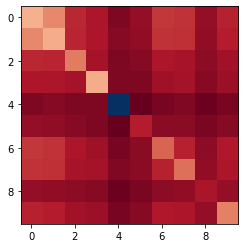

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest", cmap = "RdBu")
plt.show()


In [5]:
print(mu)
print('\n')
print(sigma)

[0.00060799 0.00025415 0.00077747 0.00087057 0.0007757  0.00026039
 0.00098033 0.00083714 0.00052564 0.00102828]


[[2.88684305e-04 2.34971277e-04 1.19144127e-04 9.55395051e-05
  4.08374189e-05 6.43415761e-05 1.38300002e-04 1.30544165e-04
  6.57854558e-05 1.10656332e-04]
 [2.34971277e-04 2.80145470e-04 1.15153528e-04 9.54200295e-05
  5.13613699e-05 5.99448196e-05 1.32392267e-04 1.26401985e-04
  6.23944184e-05 1.03452822e-04]
 [1.19144127e-04 1.15153528e-04 2.18813063e-04 8.54311072e-05
  3.96728139e-05 5.10112761e-05 9.41634004e-05 8.83810317e-05
  5.82220143e-05 8.18212026e-05]
 [9.55395051e-05 9.54200295e-05 8.54311072e-05 2.81508833e-04
  3.96940697e-05 4.02543549e-05 7.79386750e-05 8.60283778e-05
  5.09758382e-05 7.56035397e-05]
 [4.08374189e-05 5.13613699e-05 3.96728139e-05 3.96940697e-05
  8.65383135e-04 1.28354559e-05 3.42465145e-05 4.41188586e-05
  2.26116537e-05 3.61278354e-05]
 [6.43415761e-05 5.99448196e-05 5.10112761e-05 4.02543549e-05
  1.28354559e-05 1.03132587e-04 5.5883

In [6]:
q = 0.5  # set risk factor
budget = num_assets // 10  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00014434215272146955*x_0^2 + 0.00023497127740539..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [7]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [8]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], value -0.0009

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 1]	-0.0009		1.0000
[0 1 1 1 1 1 1 1 1 0]	49.5729		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.2909		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.1853		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.2917		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.1859		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.1855		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1035		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.2918		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.1860		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.1857		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1036		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.1864		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1042		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1038		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0454		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.2916		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.1858		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.1854		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1033		0.0000
[1 1 0 1 0 0 1 0 1 0]	16.1862		0.0000
[0 1 0 1

In [9]:
#### VQE solution
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], value -0.0009

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0001		0.6463
[0 0 0 0 0 0 1 0 0 0]	-0.0009		0.3464
[0 1 0 1 0 0 0 0 0 0]	1.0110		0.0008
[0 1 0 0 0 0 0 0 1 0]	1.0112		0.0007
[0 0 0 1 0 0 0 0 0 0]	-0.0007		0.0007
[0 0 0 1 0 0 1 0 0 0]	1.0102		0.0006
[1 1 0 0 0 0 0 0 0 0]	1.0114		0.0006
[0 1 0 0 0 0 0 1 0 0]	1.0110		0.0005
[1 0 0 0 0 0 1 0 0 0]	1.0105		0.0005
[0 1 0 0 0 0 1 0 0 0]	1.0109		0.0004
[0 1 0 1 0 0 1 0 0 0]	4.0455		0.0003
[0 0 0 0 0 1 0 0 0 0]	-0.0002		0.0003
[0 0 0 0 0 0 1 1 0 0]	1.0102		0.0002
[0 1 0 0 0 0 0 0 0 1]	1.0108		0.0002
[1 0 0 0 0 0 0 0 0 0]	-0.0005		0.0001
[0 1 0 0 0 1 1 0 0 0]	4.0460		0.0001
[0 0 0 0 0 0 0 1 0 0]	-0.0007		0.0001
[0 0 0 0 0 0 1 0 1 0]	1.0104		0.0001
[0 1 0 0 0 1 0 0 0 0]	1.0115		0.0001
[0 0 0 0 0 0 0 0 0 0]	1.0117		0.0001
[0 0 1 0 0 0 1 0 0 0]	1.0103		0.0001
[0 0 0 0 0 1 0 0 

In [10]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], value -0.0009

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0117		0.2137
[0 0 0 0 1 0 0 0 0 0]	-0.0003		0.0670
[0 0 0 0 0 0 0 0 0 1]	-0.0009		0.0670
[0 0 0 0 0 0 0 0 1 0]	-0.0005		0.0669
[0 0 0 1 0 0 0 0 0 0]	-0.0007		0.0669
[0 0 0 0 0 0 1 0 0 0]	-0.0009		0.0669
[0 0 0 0 0 1 0 0 0 0]	-0.0002		0.0669
[0 0 1 0 0 0 0 0 0 0]	-0.0007		0.0669
[0 0 0 0 0 0 0 1 0 0]	-0.0007		0.0669
[1 0 0 0 0 0 0 0 0 0]	-0.0005		0.0668
[0 1 0 0 0 0 0 0 0 0]	-0.0001		0.0667
[0 0 0 0 0 0 1 0 0 1]	1.0100		0.0025
[0 0 0 1 0 0 0 0 0 1]	1.0102		0.0025
[0 0 0 0 0 0 0 0 1 1]	1.0104		0.0025
[0 0 0 0 1 0 0 0 0 1]	1.0105		0.0025
[0 0 0 1 0 0 1 0 0 0]	1.0102		0.0025
[0 0 0 0 0 0 0 1 0 1]	1.0102		0.0025
[0 0 1 0 0 0 0 0 0 1]	1.0102		0.0025
[0 0 0 1 1 0 0 0 0 0]	1.0107		0.0025
[0 0 0 1 0 0 0 0 1 0]	1.0106		0.0025
[0 0 0 0 1 0 1 0 0 0]	1.0105		0.0025
[0 0 0 0 0 0 

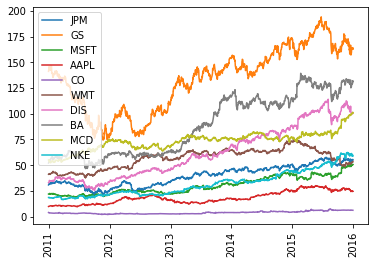

In [11]:
stocks = ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2011, 1, 1),
            end=datetime.datetime(2015, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()